## FOREX Volatility Analysis with Python

In [1]:
# the standard stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# time series things
import arch
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.api import qqplot
from scipy.stats import normaltest

# some python I wrote to do some of the dirty work
import DataLoader as dl
import Helpers as hlp

%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 25 days


## Step 1
<img src="https://i.imgflip.com/r74yt.jpg" style="vertical-align: left;">

The test set will be from 1-1-2015 through 1-1-2016, the train set will be the three years prior to that. First we'll look at one of most volatile currencies the GBP/AUD (Great Britain Pound / Australian Dollar)

In [2]:
train, test = dl.load_test_train('GBP_AUD')
train_volatility = hlp.rolling_standard_dev(train.values)
test_volatility = hlp.rolling_standard_dev(test.values)

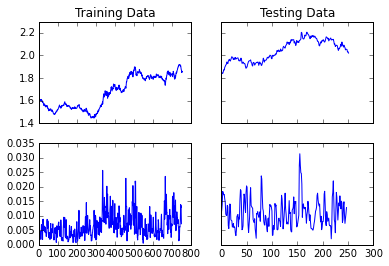

In [3]:
fig, axes = plt.subplots(2,2,sharey='row',sharex='col')

axes[0,0].set_title('Training Data')
axes[0,0].plot(train.values)
axes[0,1].set_title('Testing Data')
axes[0,1].plot(test.values)
axes[1,0].plot(train_volatility)
axes[1,1].plot(test_volatility)

## Step 2 - ACF and PACF plots. 
We're starting with an ARMA model, so the ACF and PACF plots help us choose parameters.

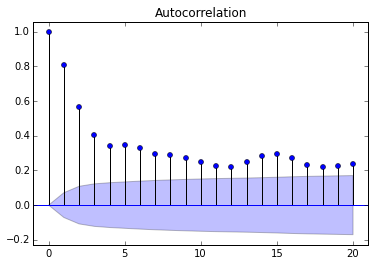

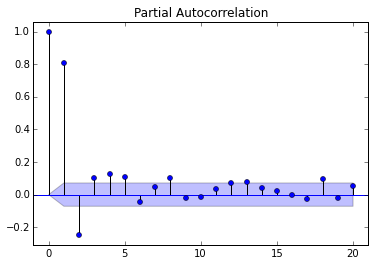

In [4]:
plot_acf(train_volatility, lags=20)
plot_pacf(train_volatility, lags=20)
plt.figure()

Looks like the data isn't stationary yet. 

A common technique to make time series data is to <a href="http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.diff.html">diff</a> it, so lets do that.

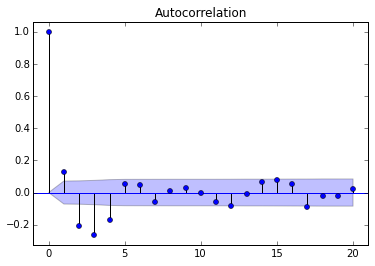

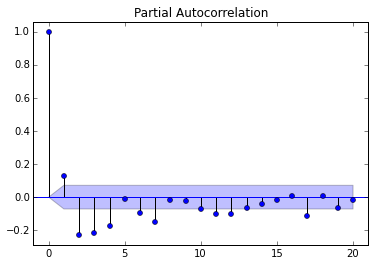

In [5]:
training_diff = np.diff(train_volatility)
plot_acf(training_diff, lags=20)
plot_pacf(training_diff, lags=20)
plt.figure()

That looks better. 

We can use the the significant lags before zero to identify the parameters for our ARMA model. More info <a href="http://www.stats.ox.ac.uk/~burke/Autocorrelation/Time%20Series%20Graphs.pdf">here</a>. According to our graphs we'll use an ARMA(1,1) model.

## Step 3 - Train Our Model

In [6]:
arma = sm.tsa.ARMA(training_diff, (1,1)).fit()
print 'Const:{}\nAR:{}\nMA:{}'.format(arma.params[0],arma.params[1],arma.params[2])

Const:5.28848879347e-06
AR:0.759342666881
MA:-0.982173402517


## Step 4 - Evaluate Our Model

The <a href="https://en.wikipedia.org/wiki/Akaike_information_criterion">Akaike information criterion (AIC)</a> and <a href="https://en.wikipedia.org/wiki/Bayesian_information_criterion">Bayesian information criterion (BIC)</a> tests are criteria by which you can compare two models against each other. We only have one model, but if there were multiple models, we would be looking for the model that minimizes those values.

In [7]:
print 'AIC:{}\nBIC:{}'.format(arma.aic,arma.bic)

AIC:-6933.27557491
BIC:-6914.7899523


Lets look at the residuals, for our ARMA to be effective they need to resemble <a href="https://en.wikipedia.org/wiki/White_noise">white noise</a> becuase we are using maximum liklihood estimation based on white noise. We can evaluate this a few ways...

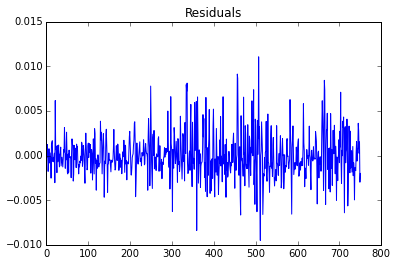

In [8]:
# get residuals
resids = arma.resid.squeeze()

plt.title('Residuals')
plt.plot(resids)

### Normal Test
The first is the <a href="http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.normaltest.html">Normal Test</a>. We want a p-value of greater than .05

In [9]:
print normaltest(resids)

NormaltestResult(statistic=83.081004054298802, pvalue=9.1030974956029877e-19)


We are no where near .05 at 0.00000000000000000091030974956029877.

But we'll also look at the qq plot. If our residuals are normally distributed, then our graph will look similar to this:

<img src="http://emp.byui.edu/BrownD/Stats-intro/dscrptv/graphs/QQ-plot-Normal1.png"/>

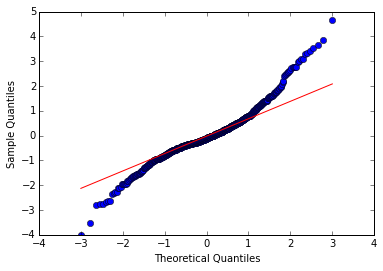

In [10]:
qqplot(resids, line='q', fit=True)
plt.figure()

## Step 5 - New Model!

Because our tests suggest that the residuals are not like white noise we are going to switch to an <a href="https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity">GARCH</a> model, which are for variances in volatility. The most common model for GARCH is GARCH(1,1)(which is the default setting for `arch.arch_model()`) so we'll start with that. Also, we aren't assuming white noise anymore so we'll switch back to our pre-diffed training data.

In [11]:
garch = arch.arch_model(train_volatility).fit()

print '\n\n{}'.format(garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: -3171.27343635
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3193.66105987
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3202.16010018
Iteration:      4,   Func. Count:     50,   Neg. LLF: -3202.3067556
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3202.30676341
            Iterations: 7
            Function evaluations: 59
            Gradient evaluations: 4


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.087
Mean Model:             Constant Mean   Adj. R-squared:                 -0.087
Vol Model:                      GARCH   Log-Likelihood:                3202.31
Distribution:                  Normal   AIC:                          -6396.61
Method:            Maximum Likelihood   BIC:                          -6378.12
                                        No. 

The parameters that are returned fit into the model like so:
$$r_t  =  \mu + \epsilon_t$$
$$\sigma^2_t   =  \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$
$$\epsilon_t  =  \sigma_t e_t,\,\,\, e_t  \sim  N(0,1)$$
<a href="http://nbviewer.jupyter.org/github/bashtage/arch/blob/master/examples/univariate_volatility_modeling.ipynb#Specifying-Common-Models">Source</a>

## Step 6 Evaluate again!

AIC:-6396.61352681
BIC:-6378.12258151


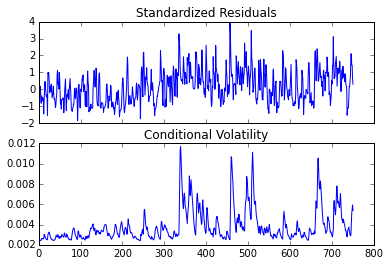

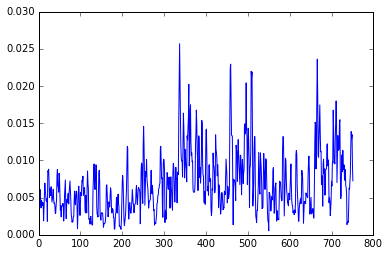

In [12]:
garch.plot()
plt.figure()
plt.plot(train_volatility)

print 'AIC:{}\nBIC:{}'.format(garch.aic, garch.bic)

In [13]:
params = garch.params['omega'],garch.params['alpha[1]'],garch.params['beta[1]']
forecaster = hlp.GarchForecaster(params)

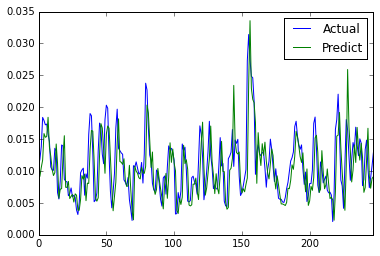

In [14]:
garch_predict = pd.Series(test_volatility,dtype=float)\
                  .apply(lambda x: forecaster.forecast(x))\
                  .shift(1)
        
dFrame = pd.DataFrame(test_volatility, columns=['Actual'])
dFrame['Predict'] = garch_predict
dFrame.plot()

Looks good. Lets add some numbers.

We'll use the <a href="https://en.wikipedia.org/wiki/Forecast_error">Mean Forecast Error</a> and the <a href="https://en.wikipedia.org/wiki/Mean_absolute_percentage_error">Mean Absolute Percentage Error</a>

In [15]:
y = dFrame.loc[1:,'Actual']
yhat = dFrame.loc[1:,'Predict']
mfe = hlp.mean_forecast_err(y,yhat)
mae = hlp.mean_absolute_err(y,yhat)

print 'MFE={}\nMAE={}'.format(mfe,mae*100)

MFE=0.000714562308353
MAE=8.41721356027
